<font color="#CC3D3D"><p>
# Build Models with BOW (ver.1108)

- `INPUT`: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- `OUTPUT`: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [2]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### 1. Read Transactions

In [3]:
train = pd.read_csv('train_transactions.csv', encoding='cp949')
test = pd.read_csv('test_transactions.csv', encoding='cp949')

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
tr = pd.concat([train, test])

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

### 2. Make Features

*BOW(Bag-Of-Words) based features*

In [4]:
level = 'gds_grp_nm'

features = pd.pivot_table(tr, index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()
#train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
#                            aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()

features

gds_grp_nm,cust_id,14K,4대 B/D,"IT 게임기,S/W",KKD,L.B,L/C 아동복,L/C골프의류,L/C정장,MP3 外,...,한실침구,한차,햄,햄세트,향수,헤어ACC,홈웨어,화장품,회,휴지류
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,0,1,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
5978,5978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5979,5979,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5980,5980,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3. Data Cleansing & Feature Engineering

*Deal with Outliers*

In [5]:
# 수치형 변수에 대해 이상치(outlier)를 처리

features.iloc[:,1:] = features.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

*Transform Features*

In [6]:
# 수치형 변수를 정규분포에 가깝게 만들기 

features.iloc[:,1:] = np.log1p(features.iloc[:,1:])

*Select Features*

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:29<00:00,  3.20it/s]

(36, 0.7426967638047381)


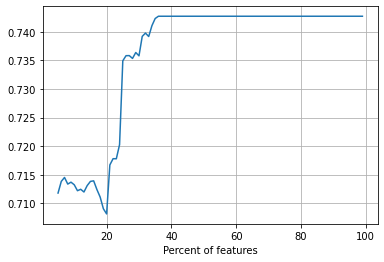

In [7]:
# 학습용과 제출용 데이터로 분리
test_id = test.cust_id.unique()
X_train = features.query('cust_id not in @test_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [7]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.iloc[:,1:].columns[fs.get_support()].tolist())

(3500, 119)
['14K', '4대 B/D', 'KKD', 'L.B', 'L/C골프의류', 'L/C정장', 'N.B', 'N.B정장', 'N/B 아동복', 'N/B골프의류', 'NB 여화', 'takeout양과', '건강식품', '건강식품(비타민)', '건강식품(홍삼)', '건과', '건생선', '계육', '곡물', '국산주방', '굴비류', '규격김치', '규격젓갈', '기초 화장품', '기초A', '기타생선', '김류', '냉동식품', '넥타이(특정)', '농산가공', '니  트', '단기행사', '돈육', '디자이너부틱', '디자이너캐릭터', '디저트류', '떡', '란제리', '면류', '멸치류', '명품잡화', '모자(특정)', '밥류', '벌크김치', '벌크젓갈', '뷰티상품', '브랑제리', '브랜드샵', '비지니스군', '산지통합', '상품군미지정', '색조 화장품', '생선', '서양델리', '선식(가루류)', '수      저', '수영복', '수입ACC', '수입단기행사', '수입소형가전', '수입식품', '수입육', '수입주방', '숙녀고정행사', '숙녀단기행사', '스카프(특정)', '스타킹(특정)', '스포츠의류', '스포츠화', '시니어', '시티웨어', '시티캐주얼', '아웃도아', '아이스크림', '안주류', '야채', '양념육', '양말(특정)', '어덜트', '어묵', '영캐주얼', '우/양산(특정)', '우육', '위생세제', '유기농야채', '유아복', '유제품', '음료', '이지캐주얼', '일반가공식품', '일반핸드백', '일식델리', '일용잡화', '장갑(특정)', '장류', '전기밥솥', '전통델리', '주류', '중식델리', '즉석.스넥(매장)', '즉석반찬', '직수입 골프의류', '직수입핸드백', '진캐주얼', '청과', '초밥', '캐릭터 남화', '캐릭터 여화', '캐릭터캐주얼', '커리어', '커피숍', '토들러', '트래디셔널Ⅰ', '트래디셔널Ⅱ', '패밀리레스토랑', '편집매장', '포숑', '

### 4. Model Tuning (Hyperparameter Optimization)

In [8]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [9]:
clfs = [
    (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': range(1,51),        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform', 'distance'],
         'metric': ['minkowski', 'euclidean', 'manhattan']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': np.arange(0.0, 1.0, 0.001),      
         'penalty': ['l1', 'l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': range(10, 310, 10),
         'max_depth': range(1, 12),
         'min_impurity_decrease': [0,0.0001,0.001,0.01,0.0002,0.002,0.02,0.0005,0.005,0.05,0.1,0.2,0.3,0.4,0.5],
         'max_features': ['auto', 'sqrt', 'log2'],
         'bootstrap': [True, False],
         'criterion': ['gini', 'entropy'], 
         'class_weight': ['balanced', 'balanced_subsample', {}],
         'min_samples_split': [2, 5, 7, 9, 10],
         'min_samples_leaf': [2, 3, 4, 5, 6]}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': range(10, 310, 10),
         'learning_rate': np.arange(0.0, 0.501, 0.001),
         'min_samples_split': [2, 4, 5, 7, 9, 10],
         'min_samples_leaf': [1, 2, 3, 4, 5],
         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
         'min_impurity_decrease': [0,0.0001,0.001,0.01,0.0002,0.002,0.02,0.0005,0.005,0.05,0.1,0.2,0.3,0.4,0.5],
         'max_features': ['auto', 'sqrt', 'log2']}
    ),
#    (
#        XGBClassifier(random_state=0),
#        {'n_estimators': range(10, 310, 10),
#         'learning_rate': np.arange(0.0, 0.501, 0.001),
#         'subsample': [0.2, 0.3, 0.5, 0.7, 0.9, 1],
#         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
#         'colsample_bytree': [0.5, 0.7, 0.9, 1],
#         'min_child_weight': [1, 2, 3, 4],
#         'reg_alpha': [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
#         'reg_lambda': [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
#         'scale_pos_weight': np.arange(0.0, 50.1, 0.1)}
#    ),
#    (
#        LGBMClassifier(random_state=0),
#        {'n_estimators': range(10, 310, 10),
#         'learning_rate': np.arange(0.0, 0.501, 0.001),
#         'num_leaves': [10,20,30,40,50,60,70,80,90,100,150,200],
#         'min_split_gain': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#         'reg_alpha': [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
#         'reg_lambda': [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
#         'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'bagging_freq': [1, 2, 3, 4, 5, 6, 7],
#         'min_child_samples': range(5,105,5)}
#    ),
#    (
#        CatBoostClassifier(random_state=0, verbose=False),
#        {'n_estimators': range(10, 310, 10),
#         'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
#         'random_strength': [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
#         'l2_leaf_reg': [1,2,3,4,5,6,7,8,9,10,20,30,50,100,200]}
#    ),    
    (
        MLPClassifier(random_state=0),
        {'batch_size': [32, 64, 128],
         'learning_rate' : ['constant', 'adaptive', 'invscaling'],
         'activation': ['tanh', 'relu', 'logistic'],
         'solver': ['sgd', 'adam'],
         'alpha': [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,0.9],
         'hidden_layer_sizes': [(32,),(64,),(128,),(32,16),(64,32,16)]}
    ),    
]

clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    clf_name = type(clf).__name__
    iterations = 10 if clf_name in ['MLPClassifier'] else 30
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=iterations, scoring='roc_auc', 
                                     cv=5, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

 20%|████████████████▊                                                                   | 1/5 [00:14<00:57, 14.35s/it]

KNeighborsClassifier                                 0.725972 14.4


 40%|█████████████████████████████████▌                                                  | 2/5 [00:15<00:31, 10.45s/it]

LogisticRegression                                   0.751610 1.4


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:29<00:22, 11.33s/it]

RandomForestClassifier                               0.730037 13.4


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:46<00:13, 13.04s/it]

GradientBoostingClassifier                           0.746452 17.0


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:23<00:00, 16.71s/it]

MLPClassifier                                        0.753340 37.4


### 5. Model Ensemble

*Correlation between models*

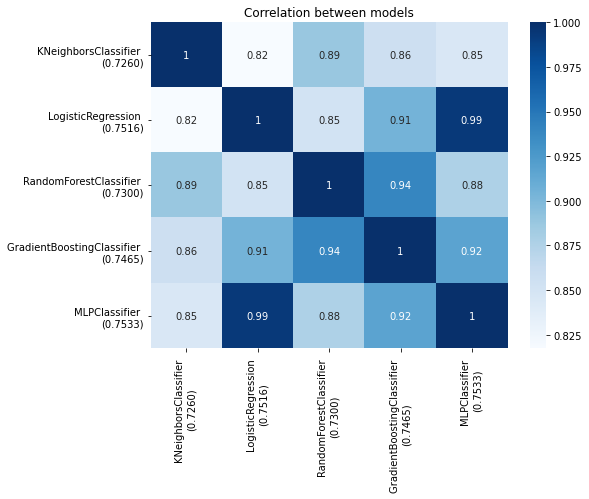

In [10]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Mean agreement vs. Performance*

In [11]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

KNeighborsClassifier \n(0.7260)          0.852019
LogisticRegression \n(0.7516)            0.891933
RandomForestClassifier \n(0.7300)        0.889315
GradientBoostingClassifier \n(0.7465)    0.904684
MLPClassifier \n(0.7533)                 0.908352
dtype: float64

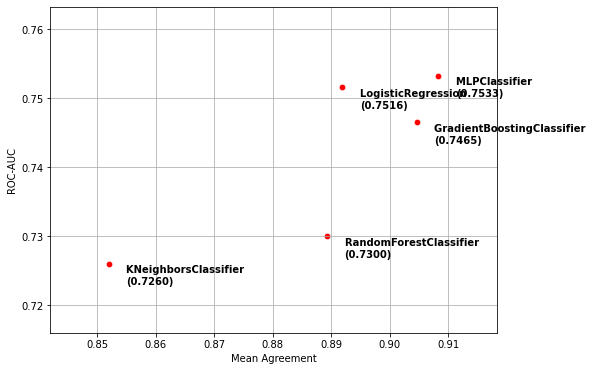

In [12]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

*Averaging Ensemble*

In [13]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
#    'CatBoostClassifier'
#    'XGBClassifier',
#    'LGBMClassifier',
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [14]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.07s/it]

p=2.56
GradientBoostingClassifier●MLPClassifier
0.7562915670102285


<font color="#CC3D3D"><p>
!!! 아래 셀 코드의 버그를 수정하였음 !!!

In [15]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in self.estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in self.estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in self.estimators], axis=0)
        else:
            probs = [clf.predict_proba(X) for name, clf in self.estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train)    

*Stacking*

In [16]:
# 2-layer stacking

# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier', 
#    'CatBoostClassifier'
#    'XGBClassifier',
#    'LGBMClassifier',
]

estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
stk_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=0), cv=5)

stk_clf.fit(X_train, y_train)
print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1])) 

0.7541816559083383


### 6. Deployment

In [17]:
# Averaging ensemble을 적용한 submission: (결과) 0.783475
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(X_test)[:,1]}).to_csv('submission_avg.csv', index=False)

# Stacking ensemble을 적용한 submission: (결과) 0.782333
pd.DataFrame({'cust_id': test_id, 'gender': stk_clf.predict_proba(X_test)[:,1]}).to_csv('submission_stk.csv', index=False)

<font color="#CC3D3D"><p>
# End